In [2]:
import os
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# CPU 상에서 5개 클래스 학습 및 평가

In [3]:
import sys
import tensorflow.keras
from tensorflow.python.client import device_lib

print(sys.version)
print('-'*50)
!python --version
print('-'*50)
print('tensorflow:{}'.format(tensorflow.keras.__version__))
print('-'*50)
print("Num GPUs Available:",len(tf.config.experimental.list_physical_devices('GPU')))
for i in tf.config.list_physical_devices('GPU'):
    print(i)   
for i in device_lib.list_local_devices()[-len(tf.config.experimental.list_physical_devices('GPU')):]:
    print('-'*50)
    print(i)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
--------------------------------------------------
Python 3.6.10 :: Anaconda, Inc.
--------------------------------------------------
tensorflow:2.6.0
--------------------------------------------------
Num GPUs Available: 0
--------------------------------------------------
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2986072229991259913



In [7]:
df = pd.read_csv('./data/clustering2.csv', encoding='utf-8', index_col=0)

In [8]:
from sklearn.model_selection import train_test_split

X = []
y = []

path = './data/2_15_crop'

for i in tqdm_notebook(range(5)):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 2400, replace=False)
    for file in random_set:
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        X.append(dst)
        y.append(df[df['filename'] == file]['cluster'].values[0]) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
%%time

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

X_train, X_test = X_train/255.0, X_test/225.0

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
from keras.applications.inception_v3 import preprocess_input


input_shape = (299, 299, 3)

base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(5, activation='softmax'))

model = add_model

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
300/300 [==============================] - 225s 734ms/step - loss: 0.5436 - accuracy: 0.7845 - val_loss: 0.3219 - val_accuracy: 0.8821
Epoch 2/10
300/300 [==============================] - 215s 716ms/step - loss: 0.3414 - accuracy: 0.8617 - val_loss: 0.3111 - val_accuracy: 0.8746
Epoch 3/10
300/300 [==============================] - 215s 717ms/step - loss: 0.3237 - accuracy: 0.8731 - val_loss: 0.3100 - val_accuracy: 0.8838
Epoch 4/10
300/300 [==============================] - 216s 720ms/step - loss: 0.3051 - accuracy: 0.8758 - val_loss: 0.2821 - val_accuracy: 0.8879
Epoch 5/10
300/300 [==============================] - 216s 720ms/step - loss: 0.2974 - accuracy: 0.8778 - val_loss: 0.2795 - val_accuracy: 0.8925
Epoch 6/10
300/300 [==============================] - 219s 731ms/step - loss: 0.2937 - accuracy: 0.8771 - val_loss: 0.2718 - val_accuracy: 0.8938
Epoch 7/10
300/300 [==============================] - 219s 731ms/step - loss: 0.2892 - accuracy: 0.8827 - val_loss: 0.2686 -

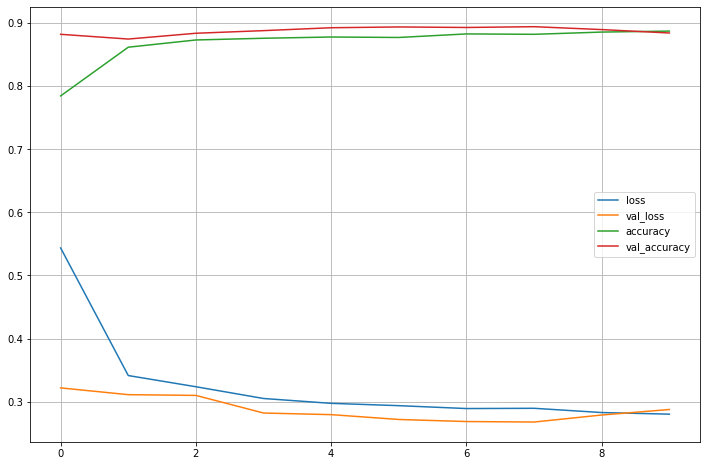

In [8]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [9]:
model.save_weights('server_cpu1_w.h5')

In [10]:
model.save('server_cpu1.h5')

# 저장된 모델 불러와서 실제 5개 클러스터 데이터에 적용

In [4]:
load_model = load_model('./server_cpu1.h5')

## 1. test 데이터에 그대로 적용(실제로 validation data)

In [10]:
len(X_train), len(y_train)

(9600, 9600)

In [11]:
len(X_test), len(y_test)

(2400, 2400)

In [12]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
%%time
# load된 모델을 평가
loss, acc = load_model.evaluate(X_test,  y_test, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))
print('복원된 모델의 Loss: {:5.2f}%'.format(100*loss))

75/75 - 45s - loss: 0.2676 - accuracy: 0.8892
복원된 모델의 정확도: 88.92%
복원된 모델의 Loss: 26.76%
CPU times: user 14min, sys: 59.1 s, total: 14min 59s
Wall time: 49.2 s


In [14]:
%%time
y_predict = load_model.predict(X_test)

CPU times: user 13min 34s, sys: 59.9 s, total: 14min 34s
Wall time: 48.5 s


In [15]:
print(y_predict.shape)

(2400, 5)


In [16]:
y_predict[:5]

array([[6.4050313e-05, 8.6615513e-11, 9.9624026e-01, 5.4884441e-07,
        3.6951203e-03],
       [1.1046553e-02, 2.2034909e-12, 9.8719132e-01, 1.2955753e-03,
        4.6643821e-04],
       [2.7144633e-05, 4.1059011e-14, 9.9997199e-01, 8.6652827e-09,
        8.5897597e-07],
       [3.6697288e-03, 8.5906733e-12, 9.9626368e-01, 1.5548125e-05,
        5.1082738e-05],
       [4.6188685e-05, 1.0998017e-02, 3.5907360e-06, 8.6774044e-06,
        9.8894358e-01]], dtype=float32)

In [17]:
y_pred = []

for i in y_predict:
    i = list(i)
    tmp = max(i)
    index = i.index(tmp)
    y_pred.append(index)

y_pred[:5]

[2, 2, 2, 2, 4]

In [18]:
y_test

array([2, 2, 2, ..., 0, 3, 3])

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[370,   1,  81,  11,  17],
       [  0, 465,   0,  11,   4],
       [ 12,   0, 448,   8,  12],
       [  7,  19,  11, 438,   5],
       [  2,  10,  48,   7, 413]])

## 2. 다시 샘플링하여 새로운 데이터 적용(replace = False)

In [31]:
from sklearn.model_selection import train_test_split

XX = []
yy = []

path = './data/2_15_crop'

for i in tqdm_notebook(range(5)):
    random_set = np.random.choice(df[df['cluster']==i]['filename'].values, 200, replace=False)
    for file in random_set:
        file_path = path + '/' + file
        src = cv2.imread(file_path, cv2.IMREAD_COLOR)
        dst = cv2.resize(src, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        XX.append(dst)
        yy.append(df[df['filename'] == file]['cluster'].values[0]) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
XX = np.array(XX)
yy = np.array(yy)

XX = XX/255.0 # 정규화!

In [33]:
len(XX), len(yy)

(1000, 1000)

In [34]:
%%time
# load된 모델을 평가
loss, acc = load_model.evaluate(XX,  yy, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))
print('복원된 모델의 Loss: {:5.2f}%'.format(100*loss))

32/32 - 18s - loss: 0.2378 - accuracy: 0.8960
복원된 모델의 정확도: 89.60%
복원된 모델의 Loss: 23.78%
CPU times: user 5min 37s, sys: 23.8 s, total: 6min 1s
Wall time: 19.5 s


In [35]:
%%time
y_predict = load_model.predict(XX)

CPU times: user 5min 38s, sys: 24.2 s, total: 6min 3s
Wall time: 19.6 s


In [36]:
print(y_predict.shape)

(1000, 5)


In [37]:
y_pred = []

for i in y_predict:
    i = list(i)
    tmp = max(i)
    index = i.index(tmp)
    y_pred.append(index)

y_pred[:5]

[0, 2, 2, 0, 0]

In [38]:
confusion_matrix(yy, y_pred)

array([[157,   0,  32,   5,   6],
       [  0, 190,   0,   7,   3],
       [  8,   0, 185,   2,   5],
       [  2,  11,   0, 184,   3],
       [  1,   1,  17,   1, 180]])

In [30]:
y_predict

array([[9.9404871e-01, 3.3752408e-06, 4.2241812e-03, 4.4440327e-04,
        1.2794056e-03],
       [4.4164324e-01, 6.7116537e-07, 4.1922766e-01, 7.0467754e-04,
        1.3842370e-01],
       [9.9898309e-01, 2.4573560e-10, 9.7712909e-04, 3.3794950e-05,
        5.9680078e-06],
       ...,
       [2.1188129e-03, 8.4071356e-04, 4.1295108e-03, 1.3071646e-04,
        9.9278027e-01],
       [1.9262862e-01, 1.9147522e-07, 6.2197280e-01, 6.5457928e-03,
        1.7885256e-01],
       [7.3900774e-02, 2.0285495e-05, 1.5798458e-01, 5.4868949e-03,
        7.6260746e-01]], dtype=float32)